In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
from tqdm import tqdm
import IPython.display as ipd

# Konfigurasi Tampilan
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# --- KONFIGURASI PATH ---
# Arahkan ke folder 'data/training' yang berisi hasil dari 0_prepare_deam.py
# Struktur: data/training/happy, data/training/sad, dll.
DEAM_DIR = 'data/training' 

# Kita ambil 1 sampel acak dari setiap mood
sample_files = {}
if os.path.exists(DEAM_DIR):
    moods = ['happy', 'sad', 'angry', 'relaxed']
    for mood in moods:
        mood_path = os.path.join(DEAM_DIR, mood)
        if os.path.exists(mood_path):
            files = [f for f in os.listdir(mood_path) if f.endswith('.mp3')]
            if files:
                # Ambil file acak biar fair, bukan cuma file pertama
                import random
                chosen = random.choice(files)
                sample_files[mood] = os.path.join(mood_path, chosen)
                print(f"✅ Sampel {mood.upper()}: {chosen}")
else:
    print("❌ Folder data tidak ditemukan! Pastikan script 0_prepare_deam.py sudah dijalankan.")

✅ Sampel HAPPY: deam_56.mp3
✅ Sampel SAD: deam_945.mp3
✅ Sampel ANGRY: deam_496.mp3
✅ Sampel RELAXED: deam_1730.mp3


In [2]:
def analyze_deam_signal(file_path, mood):
    # Load Audio
    y, sr = librosa.load(file_path, sr=22050)
    duration = len(y) / sr
    
    # --- LOGIKA POTONG ---
    # 1. Full DEAM (45s)
    y_full = y
    
    # 2. Middle 50% (Target Kita: ~22.5s)
    start_mid = int(len(y) * 0.25)
    end_mid = int(len(y) * 0.75)
    y_middle = y[start_mid:end_mid]
    
    # 3. Front 25% (Intro - Yang mau dibuang)
    y_front = y[:start_mid]
    
    # 4. Back 25% (Outro - Yang mau dibuang)
    y_back = y[end_mid:]
    
    # --- HITUNG METRIK ---
    # RMS (Root Mean Square) = Energi/Kekuatan Suara
    rms_full = np.sqrt(np.mean(y_full**2))
    rms_mid = np.sqrt(np.mean(y_middle**2))
    rms_front = np.sqrt(np.mean(y_front**2))
    rms_back = np.sqrt(np.mean(y_back**2))
    
    print(f"\n🎵 Analisis: {mood.upper()} ({os.path.basename(file_path)})")
    print(f"   Durasi Asli : {duration:.2f} detik")
    print(f"   RMS Full    : {rms_full:.4f}")
    print(f"   RMS Middle  : {rms_mid:.4f} (Target)")
    print(f"   RMS Front   : {rms_front:.4f} (Dibuang)")
    
    return y_full, y_middle, y_front, y_back, sr, rms_mid, rms_full

def plot_waveform_comparison(mood, file_path):
    y_full, y_middle, y_front, y_back, sr, rms_mid, rms_full = analyze_deam_signal(file_path, mood)
    
    plt.figure(figsize=(15, 6))
    plt.suptitle(f"DEAM Analysis: {mood.upper()} (Full vs Middle)", fontsize=16)
    
    # Plot 1: Full Song dengan Highlight Area yang Diambil
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y_full, sr=sr, color='gray', alpha=0.5, label='Discarded')
    
    # Highlight Middle Area
    time_axis = np.linspace(0, len(y_full)/sr, len(y_full))
    start_sec = (len(y_full) * 0.25) / sr
    end_sec = (len(y_full) * 0.75) / sr
    
    # Plot bagian tengah dengan warna beda
    # Kita cari index waktu untuk plotting manual agar warnanya menumpuk pas
    mid_idx_start = int(len(y_full) * 0.25)
    mid_idx_end = int(len(y_full) * 0.75)
    
    plt.plot(time_axis[mid_idx_start:mid_idx_end], y_full[mid_idx_start:mid_idx_end], 
             color='#1f77b4', label='Kept (Middle 50%)')
    
    plt.axvline(x=start_sec, color='red', linestyle='--', alpha=0.8)
    plt.axvline(x=end_sec, color='red', linestyle='--', alpha=0.8)
    plt.title(f"Waveform Full (45s) - Area Biru = Data yang Diambil")
    plt.legend()
    
    # Plot 2: Perbandingan Spektrogram (Full vs Middle)
    # Cek apakah kita kehilangan frekuensi penting?
    
    # Spec Full
    plt.subplot(2, 2, 3)
    D_full = librosa.amplitude_to_db(np.abs(librosa.stft(y_full)), ref=np.max)
    librosa.display.specshow(D_full, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram: Full (45s)")
    
    # Spec Middle
    plt.subplot(2, 2, 4)
    D_mid = librosa.amplitude_to_db(np.abs(librosa.stft(y_middle)), ref=np.max)
    librosa.display.specshow(D_mid, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram: Middle Only (22.5s)")
    
    plt.tight_layout()
    plt.show()

    # Keputusan Logis
    if rms_mid >= rms_full * 0.9:
        print("✅ KESIMPULAN: Middle 50% AMAN. Energi sinyal terjaga.")
    else:
        print("⚠️ KESIMPULAN: Hati-hati, bagian tengah lebih pelan dari rata-rata.")


🎵 Analisis: HAPPY (deam_56.mp3)
   Durasi Asli : 45.06 detik
   RMS Full    : 0.2636
   RMS Middle  : 0.2725 (Target)
   RMS Front   : 0.2510 (Dibuang)


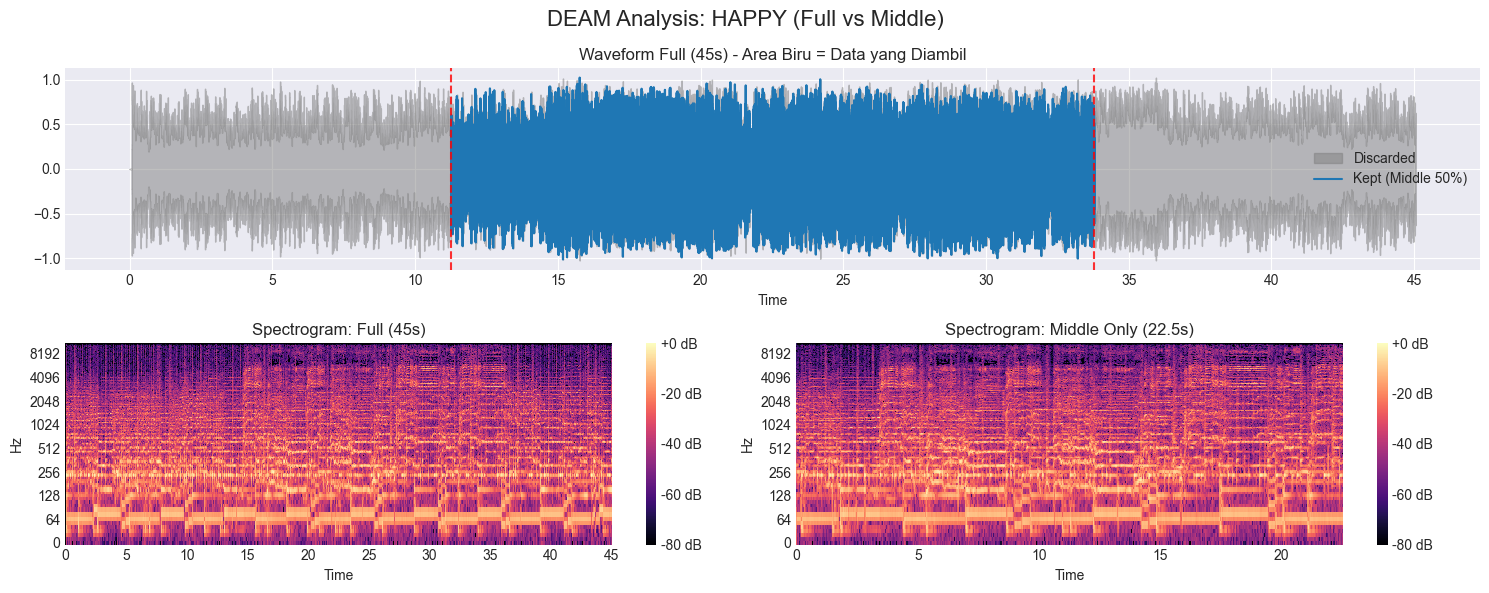

✅ KESIMPULAN: Middle 50% AMAN. Energi sinyal terjaga.

🎵 Analisis: SAD (deam_945.mp3)
   Durasi Asli : 45.06 detik
   RMS Full    : 0.0739
   RMS Middle  : 0.0743 (Target)
   RMS Front   : 0.0751 (Dibuang)


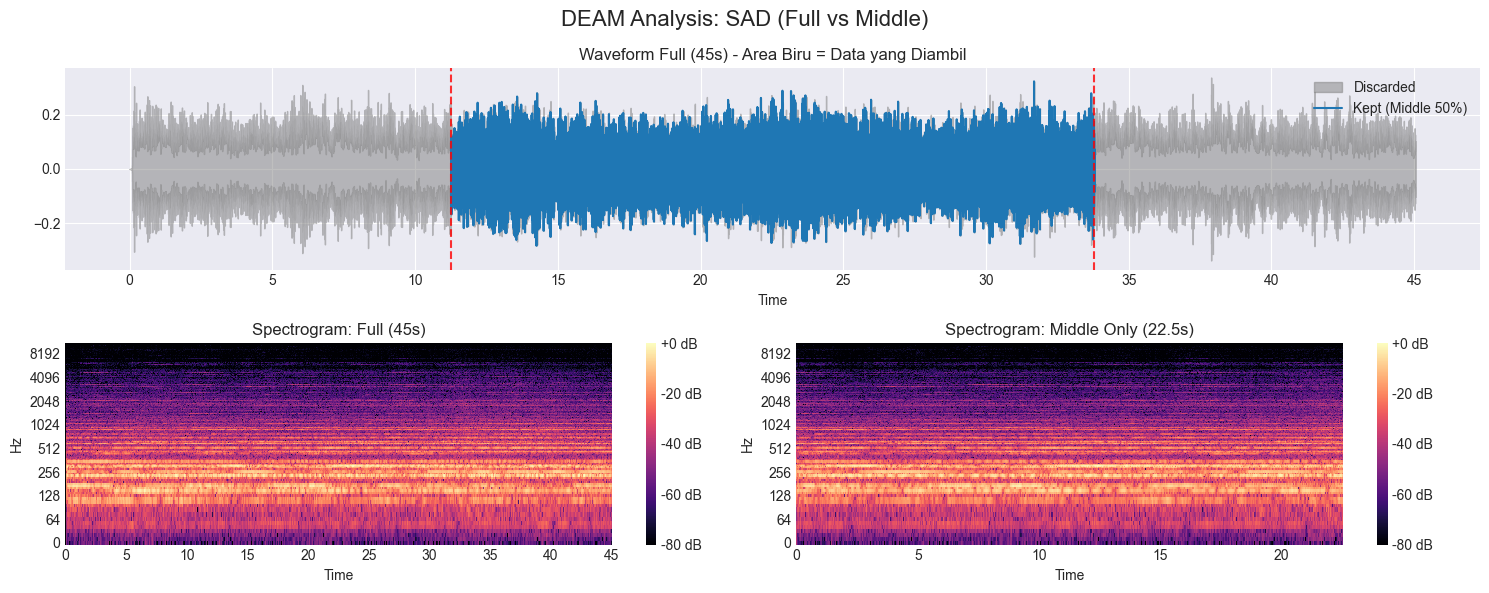

✅ KESIMPULAN: Middle 50% AMAN. Energi sinyal terjaga.

🎵 Analisis: ANGRY (deam_496.mp3)
   Durasi Asli : 45.03 detik
   RMS Full    : 0.0962
   RMS Middle  : 0.0828 (Target)
   RMS Front   : 0.1138 (Dibuang)


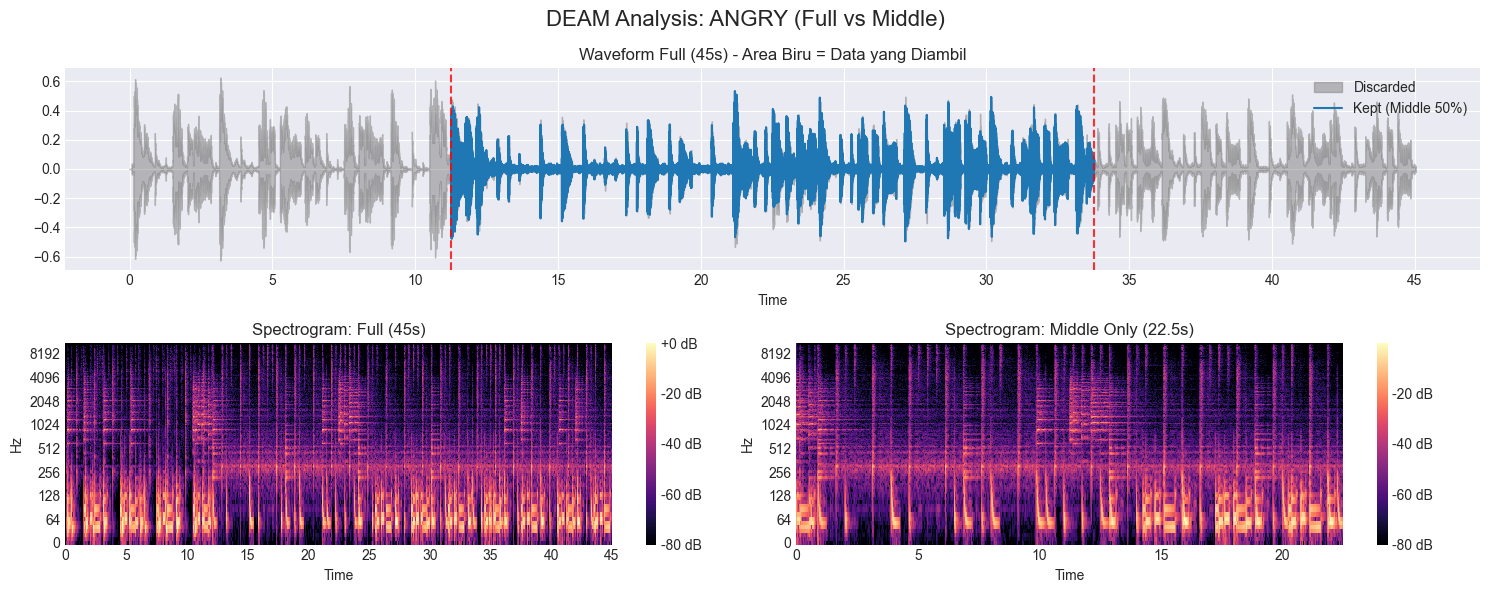

⚠️ KESIMPULAN: Hati-hati, bagian tengah lebih pelan dari rata-rata.

🎵 Analisis: RELAXED (deam_1730.mp3)
   Durasi Asli : 45.00 detik
   RMS Full    : 0.1135
   RMS Middle  : 0.1169 (Target)
   RMS Front   : 0.1070 (Dibuang)


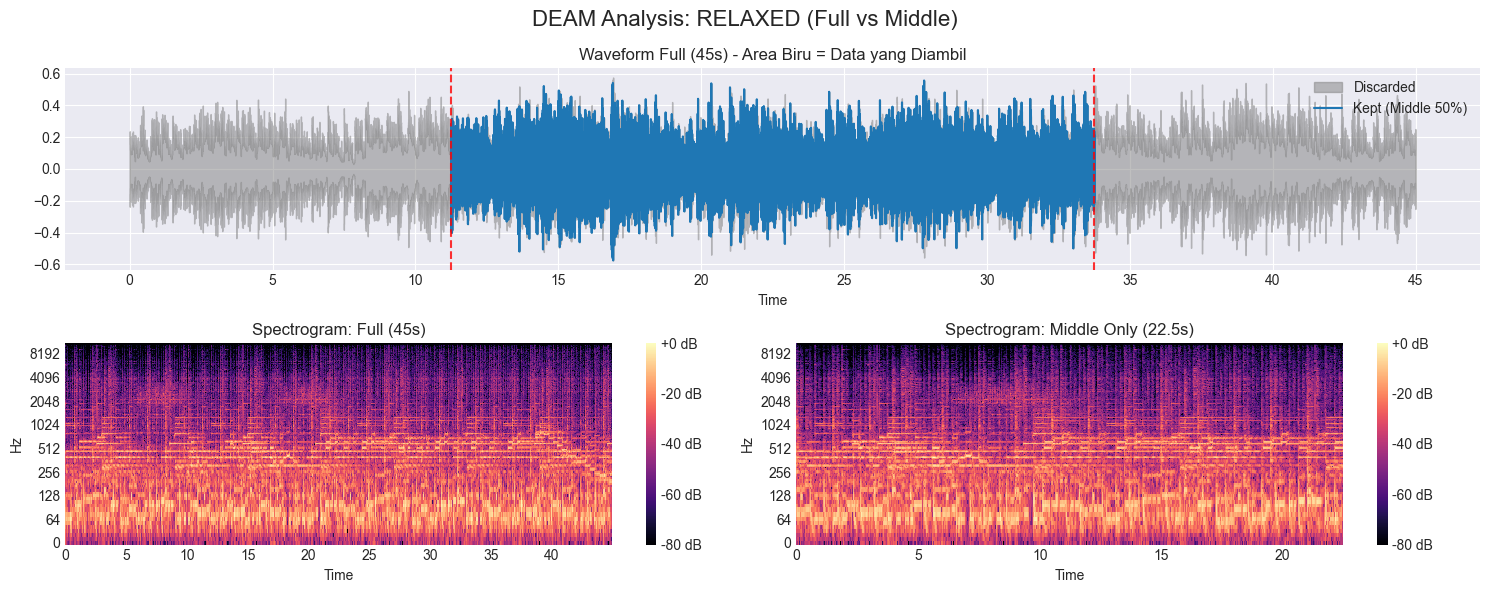

✅ KESIMPULAN: Middle 50% AMAN. Energi sinyal terjaga.


In [3]:
for mood, path in sample_files.items():
    plot_waveform_comparison(mood, path)

In [4]:
# Pilih mood yang ingin dicek
check_mood = 'sad' # Ganti 'happy', 'angry', 'relaxed'

if check_mood in sample_files:
    path = sample_files[check_mood]
    y, sr = librosa.load(path, sr=22050)
    
    # Hitung potong
    start = int(len(y) * 0.25)
    end = int(len(y) * 0.75)
    y_mid = y[start:end]
    
    print(f"🎧 Mendengarkan Sampel Middle 50% untuk: {check_mood.upper()}")
    ipd.display(ipd.Audio(y_mid, rate=sr))

🎧 Mendengarkan Sampel Middle 50% untuk: SAD
